# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier
![LeNet Architecture](lenet.png)
Source: Yan LeCun

In this project, I will use deep neural networks and convolutional neural networks to classify traffic signs. Specifically, I'll train a model to classify traffic signs from the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

Download the [dataset](https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip). This is a pickled dataset in which there are already resized the images to 32x32.

> **Note**: Here is a [link](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) to README.md file describing in details my implementation and results.



## Step 0: Load The Data

In [197]:
# Load pickled data
import pickle
import numpy as np
import random
import matplotlib.pyplot as plt

# Fill this in based on where you saved the training and testing data

training_file = './train.p'
validation_file='./valid.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [194]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s): images and distribution of classes in each dataset.

In [195]:
# Randomly choose indices to represent which datapoints we choose from the training set
import math

def plot_images(num, x, y, path):  
    num_images = num
    indices = np.random.choice(list(range(len(x))), size=num_images, replace=False)

    # Obtain the images and labels
    images = x[indices]
    labels = y[indices]

    for i, image in enumerate(images):
        plt.rcParams["figure.figsize"] = [15, 5]
        plt.subplot(2, math.ceil(num_images/2.), i+1)
        plt.imshow(image)
        plt.title('%s' % labels[i])

    plt.tight_layout()
    plt.savefig(path)
    plt.show()

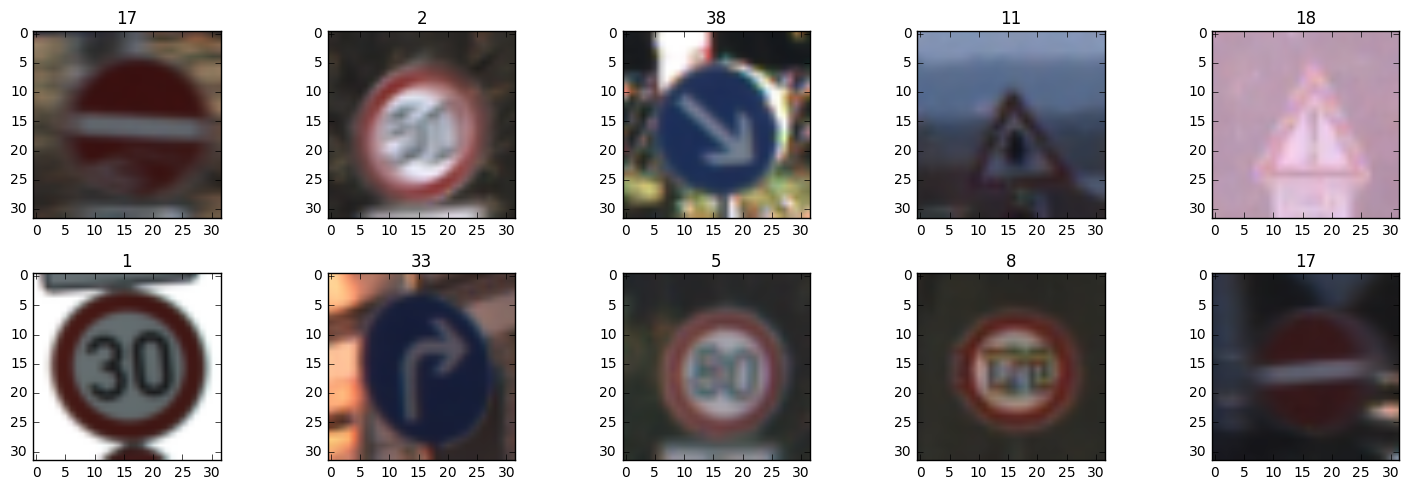

In [203]:
plot_images(10, X_train, y_train, 'writeup_images/examples_X_train.jpg')

In [191]:
# Count frequency of each label
def plot_hist(y, path):    
    labels, counts = np.unique(y, return_counts=True)

    # Plot the histogram
    plt.rcParams["figure.figsize"] = [15, 5]
    axes = plt.gca()
    axes.set_xlim([-1,43])

    plt.bar(labels, counts, tick_label=labels, width=0.8, align='center')
    plt.title('Distribution of classes on training data')
    plt.savefig(path)
    plt.show()
    

### Plot histogram of the train dataset

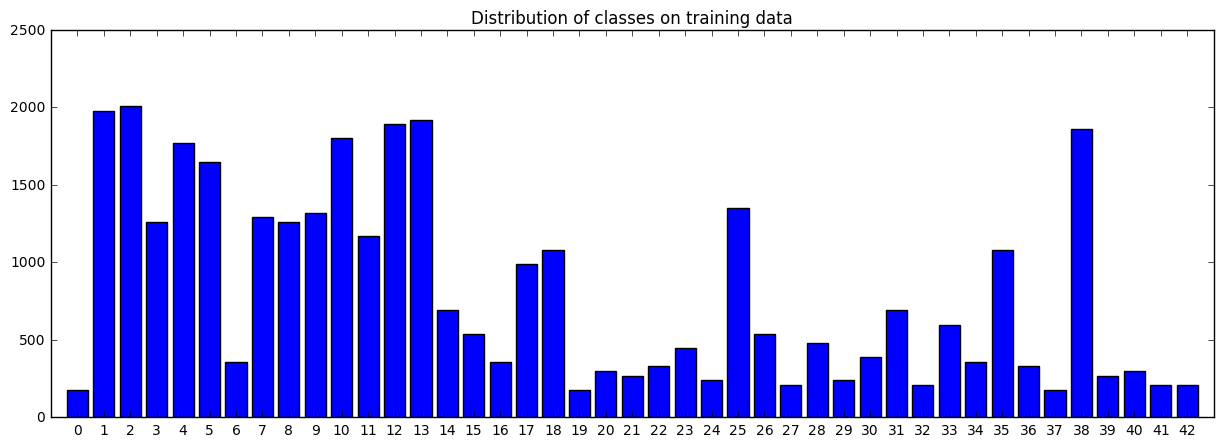

In [192]:
plot_hist(y_train, 'writeup_images/hist_y_train.jpg')

### Plot histogram of the validation dataset

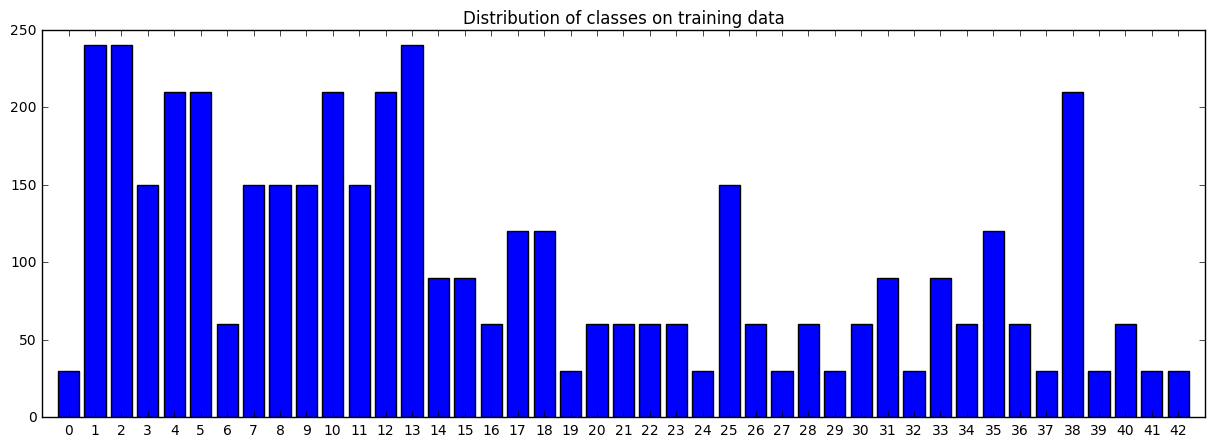

In [193]:
# Count frequency of each label
plot_hist(y_valid,'writeup_images/hist_y_valid.jpg')

### Plot histogram of the test dataset

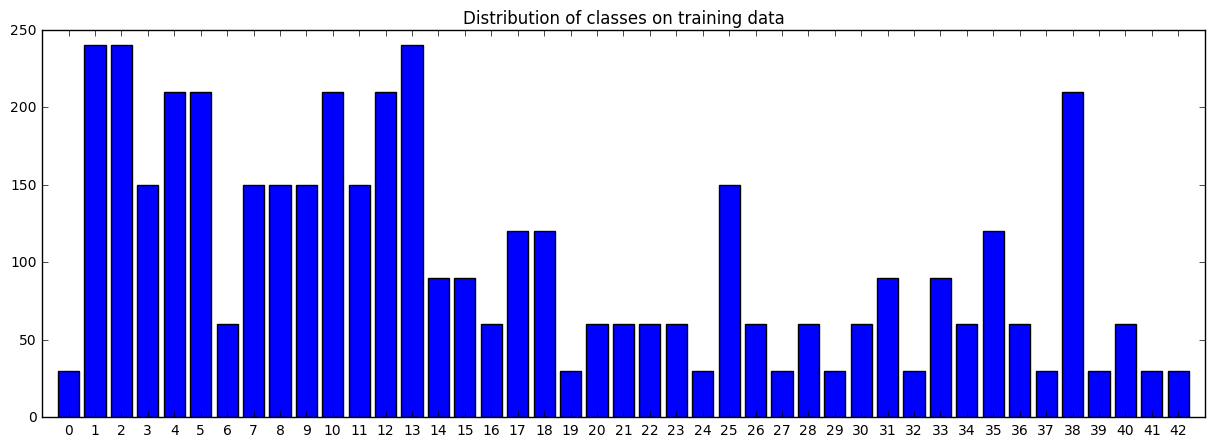

In [205]:
# Count frequency of each label
plot_hist(y_valid,'writeup_images/hist_y_test.jpg')

----

## Step 2: Design and Test a Model Architecture

In this part I will design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The implementation shown in the [LeNet-5](http://yann.lecun.com/exdb/lenet/) is a solid starting point. 
There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

In [8]:
def center_normalize(data):
    """Center normalize images"""
    data = data.astype('float32')
    data -= 128.
    data /= 128.
    return data

def convert_to_grey(data):
    images_grey = np.average(data, axis=3)
    images_grey = np.expand_dims(images_grey, axis=3)
    return images_grey

In [208]:
X_train = center_normalize(X_train)
X_valid = center_normalize(X_valid)
X_test  = center_normalize(X_test)

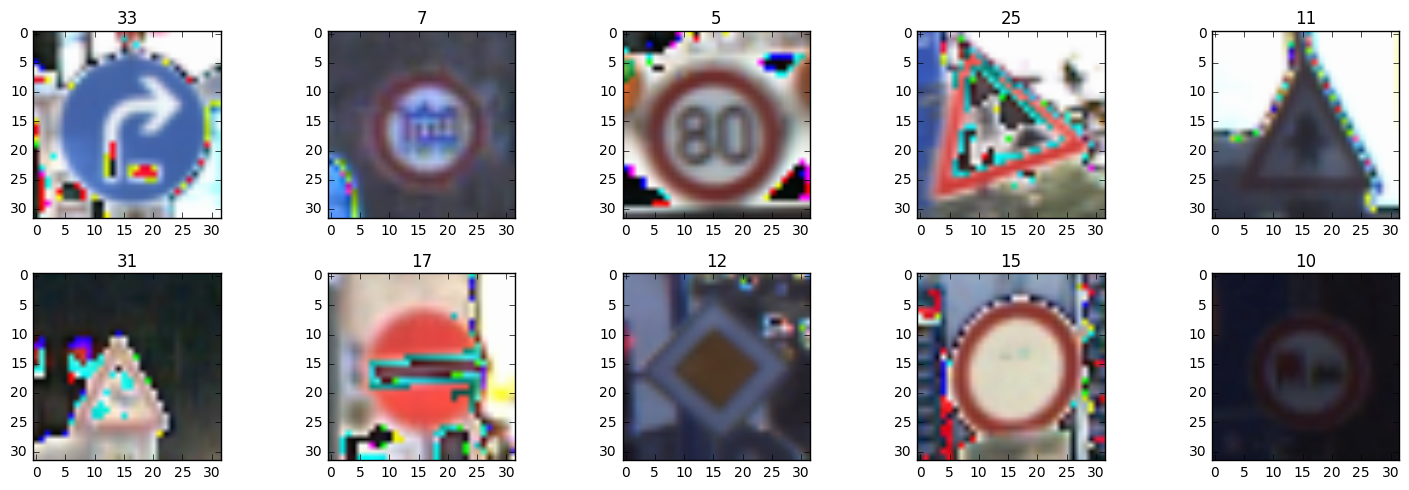

In [210]:
plot_images(10, X_train, y_train, 'writeup_images/examples_X_train_normalized.jpg')

### Model Architecture

### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since traffic signs images are RGB, and converting them to greyscale (C=1) didn't improve accuracy, I set C equals 3.

### Architecture:
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function. I used ReLU activation (https://en.wikipedia.org/wiki/Rectifier_(neural_networks).

**Pooling.** The output shape should be 14x14x6.

---
**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function. Again, I uded ReLU activation.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

---
**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** ReLU activation.

**Regularization.** I used dropout regularization with probabilty of dropout eguals 50%

---
**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** ReLU activation.

**Regularization.** I used dropout regularization with probabilty of dropout eguals 50%

---
**Layer 5: Fully Connected (Logits).** This should have 43 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [11]:
import tensorflow as tf
from sklearn.utils import shuffle

EPOCHS = 40
BATCH_SIZE = 128

In [12]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

one_hot_y = tf.one_hot(y, n_classes)

In [13]:
from tensorflow.contrib.layers import flatten

# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1

conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
conv1_b = tf.Variable(tf.zeros(6))

conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
conv2_b = tf.Variable(tf.zeros(16))

fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
fc1_b = tf.Variable(tf.zeros(120))

fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
fc2_b  = tf.Variable(tf.zeros(84))
    
fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
fc3_b  = tf.Variable(tf.zeros(n_classes))

In [206]:
def LeNet(x, dropout):    
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, dropout)
    
    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, dropout)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

#### I used regularization for the second time: L2 regulatization prevents model from overfitting. Values of Learning rate and L2 hyperparam was chosen experimentally.

In [211]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set is calculated and reported as well.

rate = 0.0007
l2_param = 0.007

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy + l2_param*(tf.nn.l2_loss(conv1_W) + \
                               tf.nn.l2_loss(conv1_b) + \
                               tf.nn.l2_loss(conv2_W) + \
                               tf.nn.l2_loss(conv2_b) + \
                               tf.nn.l2_loss(fc1_W) + \
                               tf.nn.l2_loss(fc1_b) + \
                               tf.nn.l2_loss(fc2_W) +
                               tf.nn.l2_loss(fc2_b) +
                               tf.nn.l2_loss(fc3_W) +
                               tf.nn.l2_loss(fc3_b)))
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [16]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_loss = 0
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_loss / num_examples, total_accuracy / num_examples

### Main part of the implementation. Here I traing the model on batches over all epochs (which takes a lot of time). Then the model is saved.

In [18]:
# Arrays below store data to plot loss and accuracy over epochs.
validation_loss_arr = []
training_loss_arr = []
validation_accuracy_arr = []
training_accuracy_arr = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        X_valid, y_valid = shuffle(X_valid, y_valid)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_loss, validation_accuracy = evaluate(X_valid, y_valid)
        training_loss, training_accuracy = evaluate(X_train, y_train)
        
        validation_loss_arr.append(validation_loss)
        training_loss_arr.append(training_loss)
        validation_accuracy_arr.append(validation_accuracy)
        training_accuracy_arr.append(training_accuracy)
        
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Train Loss = {:.3f}".format(training_loss))
        print("Validation Loss = {:.3f}".format(validation_loss))
        print()
        
    saver.save(sess, './traffic_signs.chkp')
    print("Model saved")
    print("Done")

Training...

EPOCH 1 ...
Train Accuracy = 0.493
Validation Accuracy = 0.438
Train Loss = 2.450
Validation Loss = 2.600

EPOCH 2 ...
Train Accuracy = 0.687
Validation Accuracy = 0.620
Train Loss = 1.624
Validation Loss = 1.775

EPOCH 3 ...
Train Accuracy = 0.805
Validation Accuracy = 0.733
Train Loss = 1.246
Validation Loss = 1.392

EPOCH 4 ...
Train Accuracy = 0.867
Validation Accuracy = 0.795
Train Loss = 1.046
Validation Loss = 1.222

EPOCH 5 ...
Train Accuracy = 0.903
Validation Accuracy = 0.839
Train Loss = 0.958
Validation Loss = 1.118

EPOCH 6 ...
Train Accuracy = 0.911
Validation Accuracy = 0.851
Train Loss = 0.885
Validation Loss = 1.040

EPOCH 7 ...
Train Accuracy = 0.920
Validation Accuracy = 0.856
Train Loss = 0.837
Validation Loss = 0.994

EPOCH 8 ...
Train Accuracy = 0.935
Validation Accuracy = 0.870
Train Loss = 0.796
Validation Loss = 0.957

EPOCH 9 ...
Train Accuracy = 0.942
Validation Accuracy = 0.875
Train Loss = 0.778
Validation Loss = 0.933

EPOCH 10 ...
Train Accur

#### Measuer the accuracy on test data.

In [31]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_loss, test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print("Test Loss = {:.3f}".format(test_loss))

Test Accuracy = 0.931
Test Loss = 0.824


#### Plot the accuracy

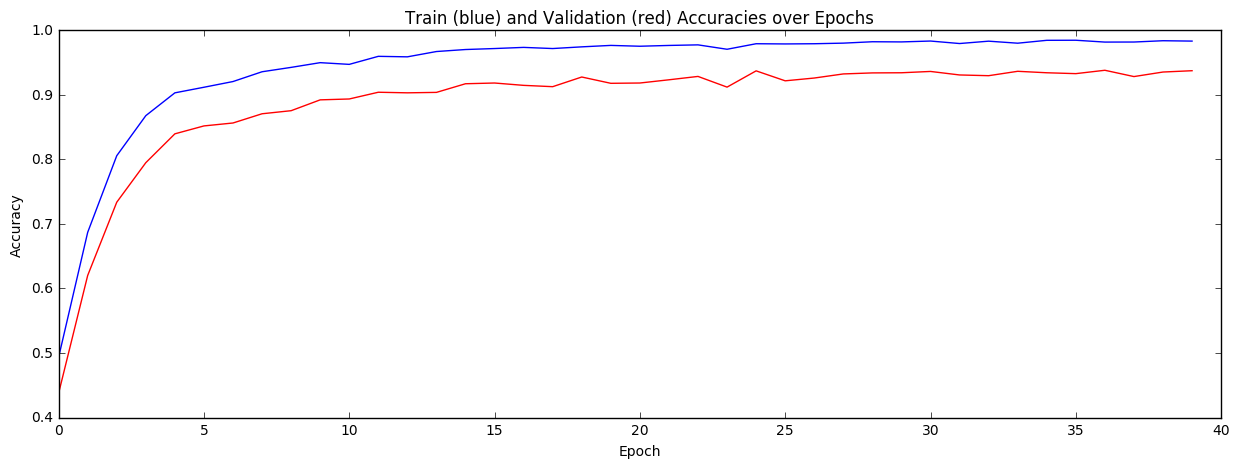

In [20]:
plt.plot(training_accuracy_arr, 'b')  # training accuracy
plt.plot(validation_accuracy_arr, 'r')  # validation accuracy
plt.rcParams["figure.figsize"] = [10, 5]
plt.title('Train (blue) and Validation (red) Accuracies over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

#### Plot the loss

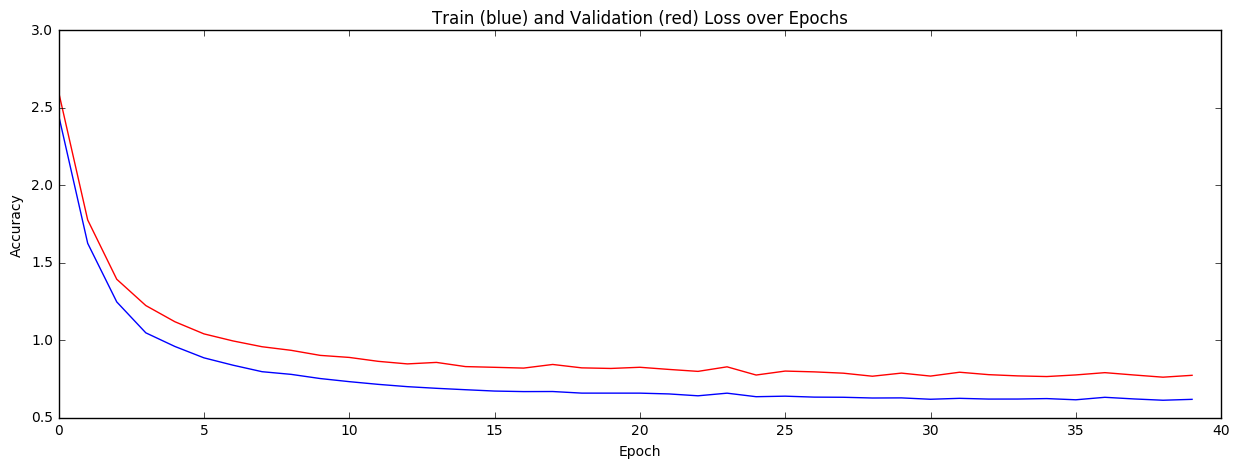

In [26]:
plt.plot(training_loss_arr, 'b')  # training loss
plt.plot(validation_loss_arr, 'r')  # validation loss
plt.rcParams["figure.figsize"] = [10, 5]
plt.title('Train (blue) and Validation (red) Loss over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, I've downloaded ten pictures of German traffic signs from the web and use your model to predict the traffic sign type.

I used `signnames.csv` as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

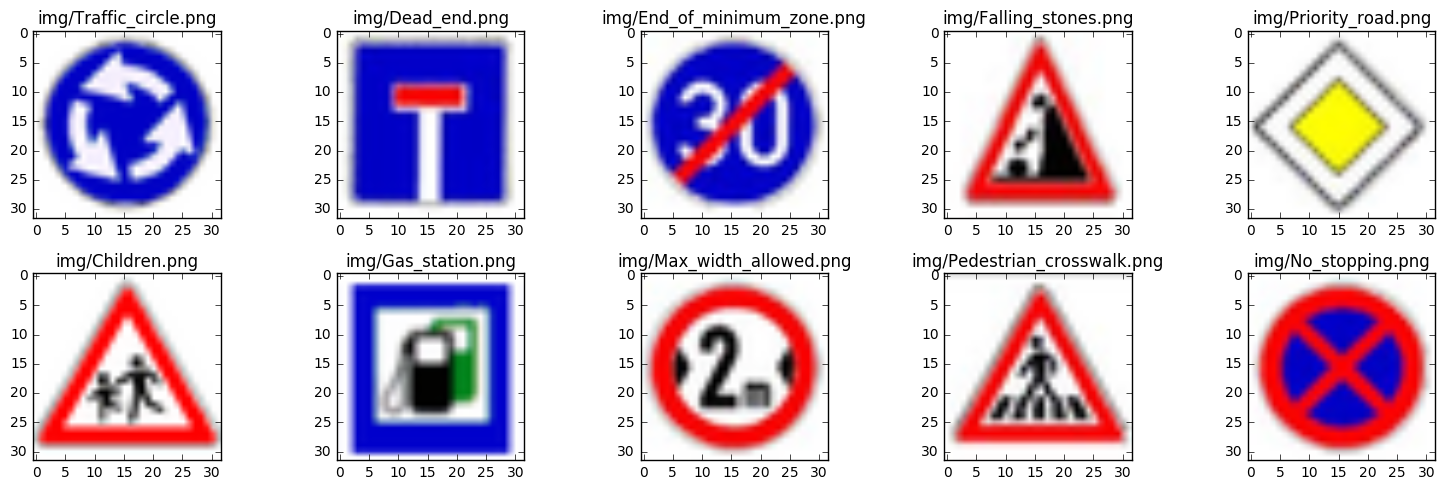

In [212]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
from PIL import Image

outside_traffic_signs  = ['img/' + image_file for image_file in os.listdir('img')]
images = []

for image_file in outside_traffic_signs:
    image = Image.open(image_file)
    image = image.convert('RGB')
    image = image.resize((image_shape[0], image_shape[1]), Image.ANTIALIAS)
    image = np.array(list(image.getdata()), dtype='uint8')
    image = np.reshape(image, (32, 32, 3))
    images.append(image)
    
outside_traffic_signs = np.array(outside_traffic_signs)    
traffic_signs = np.array(images, dtype='uint8')

plot_images(10,traffic_signs, outside_traffic_signs, 'writeup_images/examples_german_signs.jpg')

#### Make sure to pre-process the images with the same pre-processing pipeline used earlier.

In [164]:
traffic_signs = center_normalize(traffic_signs)

### Predict the Sign Type for Each Image

In [165]:
### Run the predictions here and use the model to output the prediction for each image.
# Load signnames.csv to map label number to sign string

label_map = {}
with open('signnames.csv', 'r') as file:
    first_line = True
    for line in file:
        # Ignore first line
        if first_line:
            first_line = False
            continue

        # Populate label_map
        label_int, label_string = line.split(',')
        label_int = int(label_int)

        label_map[label_int] = label_string

In [166]:
predictions = tf.argmax(logits, 1)
sm = tf.nn.softmax(logits)
top_k_val, top_k_idx = tf.nn.top_k(softmax, k=5)

def predict_taffic_sign(X_data):
    sess = tf.get_default_session()
    logit_results, prediction_results, top_k_vals, top_k_idxs, softmax_results = \
        sess.run([logits, predictions, top_k_val, top_k_idx, sm], feed_dict={x: X_data, keep_prob: 1.})
        
    return logit_results, prediction_results, top_k_vals, top_k_idxs, softmax_results

In [167]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    logit_results, prediction_results, top_k_vals, top_k_idxs, softmax_results = predict_taffic_sign(traffic_signs)
    final_preds = [label_map[pred] for pred in prediction_results]

#### Print predictions on my sample images

In [168]:
print('Predictions on traffic sign images:\n')
for i in range(traffic_signs.shape[0]):
    print('{:30} :(Prediction) {}'.format(outside_traffic_signs[i], final_preds[i]))

Predictions on traffic sign images:

img/Children.png               :(Prediction) Children crossing

img/Dead_end.png               :(Prediction) Go straight or right

img/End_of_minimum_zone.png    :(Prediction) Keep right

img/Falling_stones.png         :(Prediction) Bumpy road

img/Gas_station.png            :(Prediction) Right-of-way at the next intersection

img/Max_width_allowed.png      :(Prediction) Speed limit (70km/h)

img/No_stopping.png            :(Prediction) Priority road

img/Pedestrian_crosswalk.png   :(Prediction) General caution

img/Priority_road.png          :(Prediction) Priority road

img/Traffic_circle.png         :(Prediction) Speed limit (100km/h)



#### For each of the 10 predictions, find an image in the test set that matches the predicted class

In [169]:
train_images = []
X_train, y_train = shuffle(X_train, y_train)
for pred in prediction_results:
    for i, y in enumerate(y_train):
        if y == pred:
            train_images.append(X_train[i])
            break

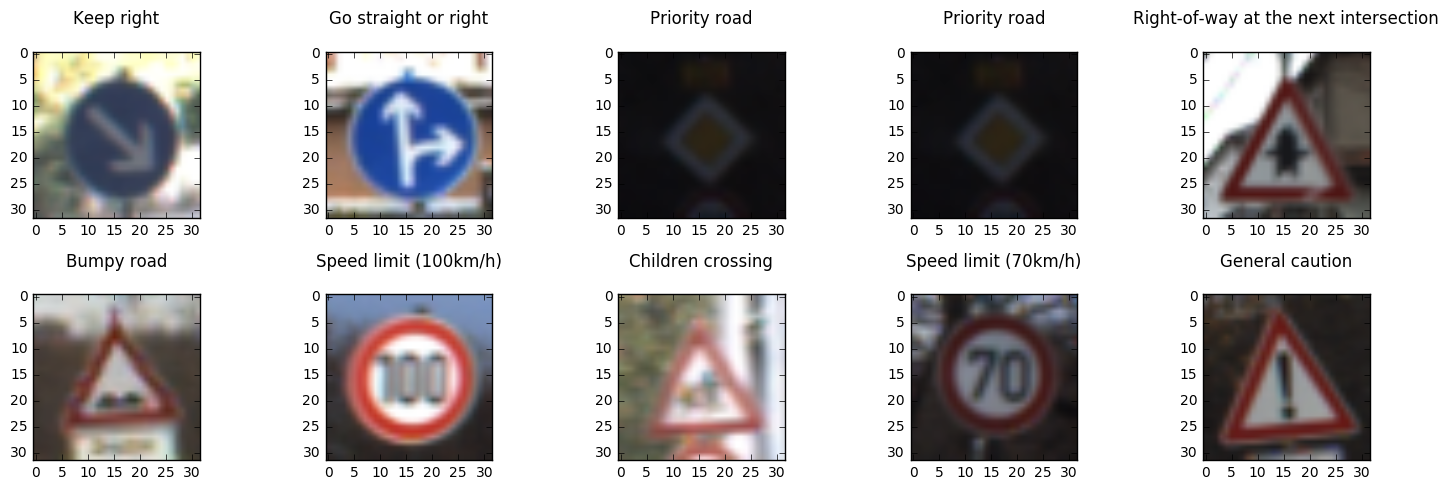

In [213]:
plot_images(10, np.array(train_images), np.array(final_preds), 'writeup_images/predicted_german_signs.jpg')

# Analyze Performance

#### CORRECT! img/Children.png               :(Prediction) Children crossing

WRONG!   img/Dead_end.png               :(Prediction) Go straight or right

WRONG!   img/End_of_minimum_zone.png    :(Prediction) Keep right

WRONG!   img/Falling_stones.png         :(Prediction) Bumpy road

WRONG!   img/Gas_station.png            :(Prediction) Right-of-way at the next intersection

WRONG!   img/Max_width_allowed.png      :(Prediction) Speed limit (70km/h)

WRONG!   img/No_stopping.png            :(Prediction) Priority road

WRONG!   img/Pedestrian_crosswalk.png   :(Prediction) General caution

#### CORRECT! img/Priority_road.png          :(Prediction) Priority road

WRONG!   img/Traffic_circle.png         :(Prediction) Speed limit (100km/h)

    
### Two out of ten prediction is correct what gives us only 20% accurate.
---

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [215]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
def pred_certainty_str(top_k_val, top_k_idx):
    # Convert top k indices into strings
    top_k_pred = [label_map[idx] for idx in top_k_idx]    
    pcs = ''
    for i in range(5):
        pcs += '{}: {:.2f}%\n'.format(top_k_pred[i].replace('\n', ''), top_k_val[i] * 100)        
    return pcs  

def plot_images2(path):    
    for i, image in enumerate(traffic_signs):
        plt.rcParams["figure.figsize"] = [15, 8]
        plt.subplot(2, 5, i+1)
        plt.imshow(image)
        plt.xlabel(pred_certainty_str(top_k_vals[i], top_k_idxs[i]))
    plt.tight_layout()
    plt.savefig(path)
    plt.show()

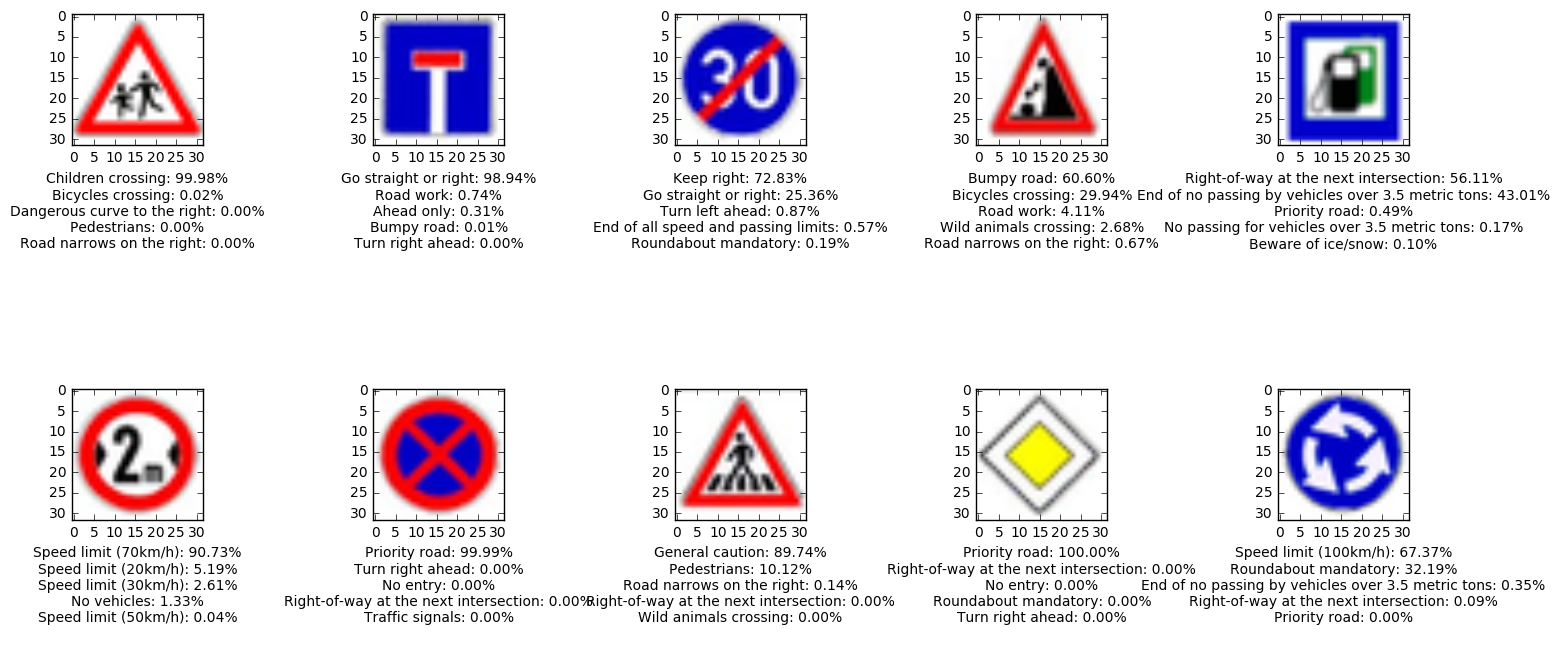

In [216]:
plot_images2('writeup_images/examples_5_softmax.jpg')